IMPORTS

In [2]:
import os
import json
import csv
import pandas as pd
from shapely.wkt import loads

JSON TO CSV

In [3]:
base_dir = 'C:/Users/Tuna/Desktop/xView2/'

def process_labels(sub_dir, output_csv):
    dir_path = os.path.join(base_dir, sub_dir)
    with open(output_csv, 'w', newline='') as csv_file:
        fieldnames = ['Filename', 'UID', 'Subtype', 'WKT']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()

        for filename in os.listdir(dir_path):
            if filename.endswith('.json'):
                file_path = os.path.join(dir_path, filename)
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    
                features = data.get('features', {})
                xy_list = features.get('lng_lat', [])

                for item in xy_list:
                    wkt = item.get('wkt')
                    properties = item.get('properties', {})
                    uid = properties.get('uid')
                    subtype = properties.get('subtype')

                    writer.writerow({
                        'Filename': filename,
                        'UID': uid,
                        'Subtype': subtype,
                        'WKT': wkt
                    })

In [4]:
process_labels('train/labels/', 'train_json_to.csv')
process_labels('hold/labels/','hold_json_to.csv')
process_labels('test/labels','test_json_to.csv')
process_labels('tier3/labels','tier3_json_to.csv')


CSV TO CSV (CALCULATIONS)

In [5]:
def process_csv(input_csv, output_csv):
    data = pd.read_csv(input_csv, header=None, names=['filename', 'uid', 'subtype', 'wkt'])

    pre_disaster_features = data[data['filename'].str.contains('pre')].set_index('uid').to_dict(orient='index')
    post_disaster_features = data[data['filename'].str.contains('post')].set_index('uid').to_dict(orient='index')

    uids = set(pre_disaster_features.keys()).intersection(post_disaster_features.keys())
    
    with open(output_csv, 'w', newline='') as csvfile:
        fieldnames = [
            'UID', 'Pre-disaster WKT', 'Post-disaster WKT', 
            'Pre-disaster Area', 'Post-disaster Area', 'Area Difference',
            'Pre-disaster Perimeter', 'Post-disaster Perimeter', 'Perimeter Difference',
            'Pre-disaster Center', 'Post-disaster Center', 'Center Distance', 'Damage'
        ]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for uid in uids:
            pre_disaster = pre_disaster_features[uid]
            post_disaster = post_disaster_features[uid]

            pre_wkt = pre_disaster.get('wkt')
            post_wkt = post_disaster.get('wkt')

            pre_polygon = loads(pre_wkt)
            post_polygon = loads(post_wkt)
            
            pre_area = pre_polygon.area
            post_area = post_polygon.area
            area_diff = abs(pre_area - post_area)

            pre_perimeter = pre_polygon.length
            post_perimeter = post_polygon.length
            perimeter_diff = abs(pre_perimeter - post_perimeter)

            pre_center = pre_polygon.centroid
            post_center = post_polygon.centroid
            center_diff = pre_center.distance(post_center)

            post_subtype = post_disaster.get('subtype')

            writer.writerow({
                'UID': uid,
                'Pre-disaster WKT': pre_wkt,
                'Post-disaster WKT': post_wkt,
                'Pre-disaster Area': pre_area,
                'Post-disaster Area': post_area,
                'Area Difference': area_diff,
                'Pre-disaster Perimeter': pre_perimeter,
                'Post-disaster Perimeter': post_perimeter,
                'Perimeter Difference': perimeter_diff,
                'Pre-disaster Center': f"{pre_center.x}, {pre_center.y}",
                'Post-disaster Center': f"{post_center.x}, {post_center.y}",
                'Center Distance': center_diff, 
                'Damage': post_subtype,
            })



In [6]:
process_csv('train_json_to.csv', 'train.csv')
process_csv('hold_json_to.csv', 'hold.csv')
process_csv('test_json_to.csv', 'test.csv')
process_csv('tier3_json_to.csv', 'tier3.csv')

CSV TO CSV (REGULATIONS)

In [7]:
def regulation_csv(input_csv, output_csv):
   
    df = pd.read_csv(input_csv)
    
    subtype_mapping = {
        'no-damage': 0,
        'minor-damage': 1,
        'major-damage': 2,
        'destroyed': 3,
        'un-classified': -1  
    }
    
    df['Damage'] = df['Damage'].map(subtype_mapping)
    
    def limit_precision(x):
        try:
            return round(float(x), 15)
        except ValueError:
            return x
    
    for col in ['Pre-disaster Area', 'Post-disaster Area', 'Pre-disaster Perimeter', 'Post-disaster Perimeter']:
        if col in df.columns:
            df[col] = df[col].apply(limit_precision)
    
    df = df.drop(columns=[ 'UID',
                          'Pre-disaster WKT', 
                          'Post-disaster WKT', 
                          'Pre-disaster Area', 
                          'Post-disaster Area', 
                          'Pre-disaster Perimeter', 
                          'Post-disaster Perimeter', 
                          'Pre-disaster Center', 
                          'Post-disaster Center'
                          ])
    
    df.to_csv(output_csv, index=False, float_format='%.15f')


In [8]:
regulation_csv('train.csv', 'regulated_train.csv')
regulation_csv('hold.csv', 'regulated_hold.csv')
regulation_csv('test.csv', 'regulated_test.csv')
regulation_csv('tier3.csv', 'regulated_tier3.csv')

MERGE


In [9]:
def combine_csv_files(file_paths, output_csv):
    
    dataframes = [pd.read_csv(file) for file in file_paths]
    
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    def limit_precision(x):
        try:
            return round(float(x), 15)
        except ValueError:
            return x
    
    for col in ['Area Difference', 'Perimeter Difference', 'Center Distance']:
        if col in combined_df.columns:
            combined_df[col] = combined_df[col].apply(limit_precision)

    if 'Damage' in combined_df.columns:
        combined_df = combined_df[combined_df['Damage'] != -1]
    
    combined_df.to_csv(output_csv, index=False, float_format='%.15f')


In [10]:
files = ['regulated_train.csv', 'regulated_test.csv', 'regulated_hold.csv', 'regulated_tier3.csv']
combine_csv_files(files, 'combine.csv')

ANALYZE


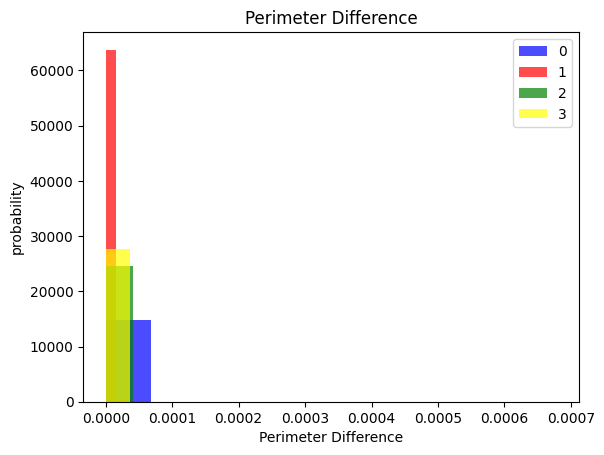

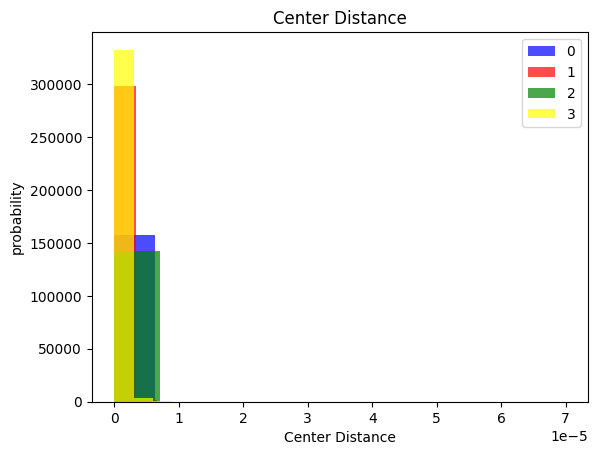

In [11]:
import pandas as pd

import matplotlib.pyplot as plt



cols = ['Perimeter Difference', 'Center Distance', 'Damage']
df=pd.read_csv('combine.csv')
for label in cols[:-1]:
    plt.hist(df[df["Damage"]==0][label], color='blue',label='0',alpha=0.7,density=True)
    plt.hist(df[df["Damage"]==1][label], color='red',label='1',alpha=0.7,density=True)
    plt.hist(df[df["Damage"]==2][label], color='green',label='2',alpha=0.7,density=True)
    plt.hist(df[df["Damage"]==3][label], color='yellow',label='3',alpha=0.7,density=True)
    plt.title(label)
    plt.ylabel("probability")
    plt.xlabel(label)
    plt.legend()
    plt.show()


TRAIN

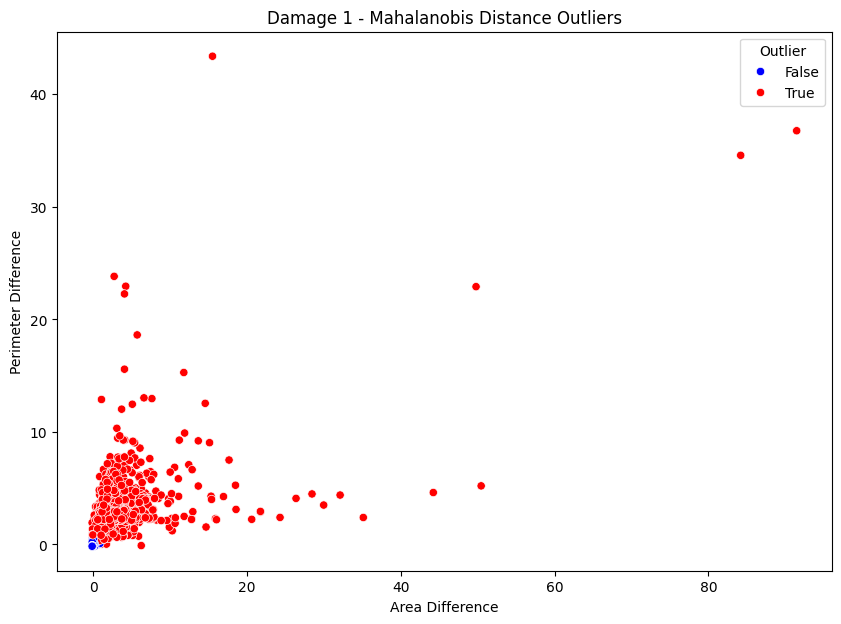

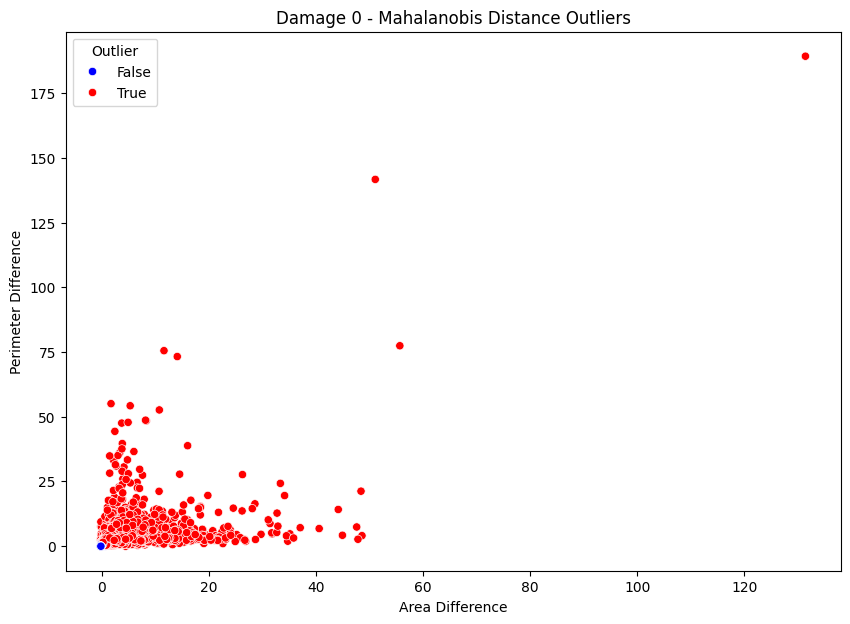

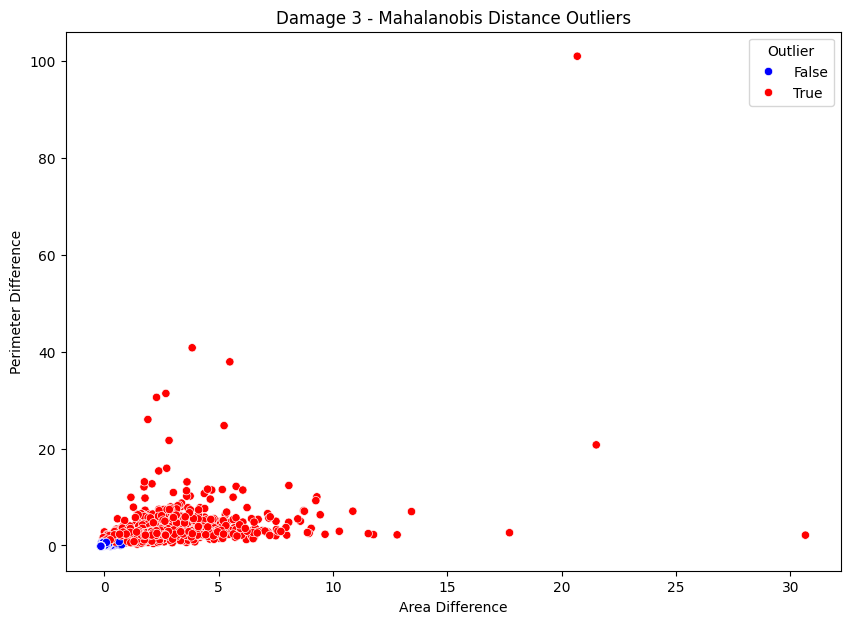

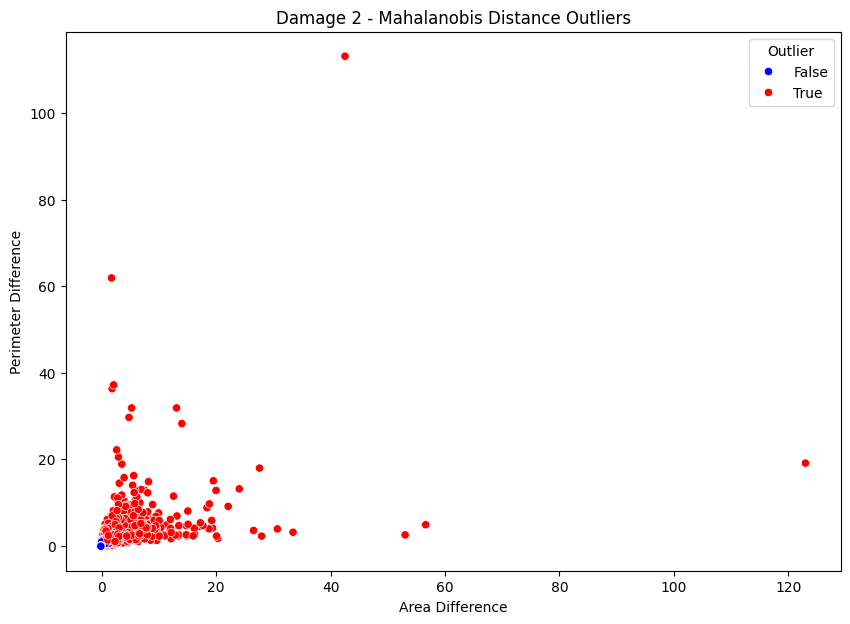

In [10]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('combine.csv')

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[['Area Difference', 'Perimeter Difference', 'Center Distance']] = scaler.fit_transform(df[['Area Difference', 'Perimeter Difference', 'Center Distance']])


def mahalanobis_distance(df_scaled):
    
    features = ['Area Difference', 'Perimeter Difference', 'Center Distance']
    mean = df_scaled[features].mean().values
    cov_matrix = np.cov(df_scaled[features].values.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    
    diff = df_scaled[features].values - mean
    m_dist = np.sqrt(np.sum(np.dot(diff, inv_cov_matrix) * diff, axis=1))
    
    return m_dist


df_scaled['Mahalanobis Distance'] = mahalanobis_distance(df_scaled)


threshold = np.percentile(df_scaled['Mahalanobis Distance'], 95)
df_scaled['Outlier'] = df_scaled['Mahalanobis Distance'] > threshold


def plot_mahalanobis_outliers(df_scaled, damage):
    filtered_df = df_scaled[df_scaled['Damage'] == damage]
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=filtered_df, x='Area Difference', y='Perimeter Difference', hue='Outlier', palette={True: 'red', False: 'blue'})
    plt.title(f'Damage {damage} - Mahalanobis Distance Outliers')
    plt.xlabel('Area Difference')
    plt.ylabel('Perimeter Difference')
    plt.legend(title='Outlier')
    plt.show()

for damage in df['Damage'].unique():
    plot_mahalanobis_outliers(df_scaled, damage)


def combine_outliers(damage_list, output_file):
    all_outliers = []
    
    for damage in damage_list:
        
        df = df_scaled[df_scaled['Damage'] == damage]
        outliers = df[df['Outlier']]
        
        outliers.loc[:, 'Damage'] = damage

        all_outliers.append(outliers)
    
    
    combined_df = pd.concat(all_outliers, ignore_index=True)
    
    combined_df.to_csv(output_file, index=False)

damage_list = [0, 1, 2, 3]

output_file = 'all_damage_outliers.csv'

combine_outliers(damage_list, output_file)


In [11]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X = df_scaled[['Area Difference', 'Perimeter Difference', 'Center Distance']]
y = df_scaled['Outlier'].astype(int) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Skoru: {f1:.4f}")


Accuracy: 0.9997
Precision: 0.9977
Recall: 0.9964
F1 Skoru: 0.9971


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Binarizer

X = df_scaled[['Area Difference', 'Perimeter Difference', 'Center Distance']]
y = df_scaled['Outlier'].astype(int) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_continuous = model.predict(X_test)

binarizer = Binarizer(threshold=0.5)
y_pred = binarizer.fit_transform(y_pred_continuous.reshape(-1, 1)).astype(int).flatten()


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Skoru: {f1:.4f}")


Accuracy: 0.9918
Precision: 1.0000
Recall: 0.8346
F1 Skoru: 0.9099


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('combine.csv')

X = df[['Area Difference', 'Perimeter Difference', 'Center Distance']]
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.7617
Precision: 0.6548
Recall: 0.7617
F1 Score: 0.6605


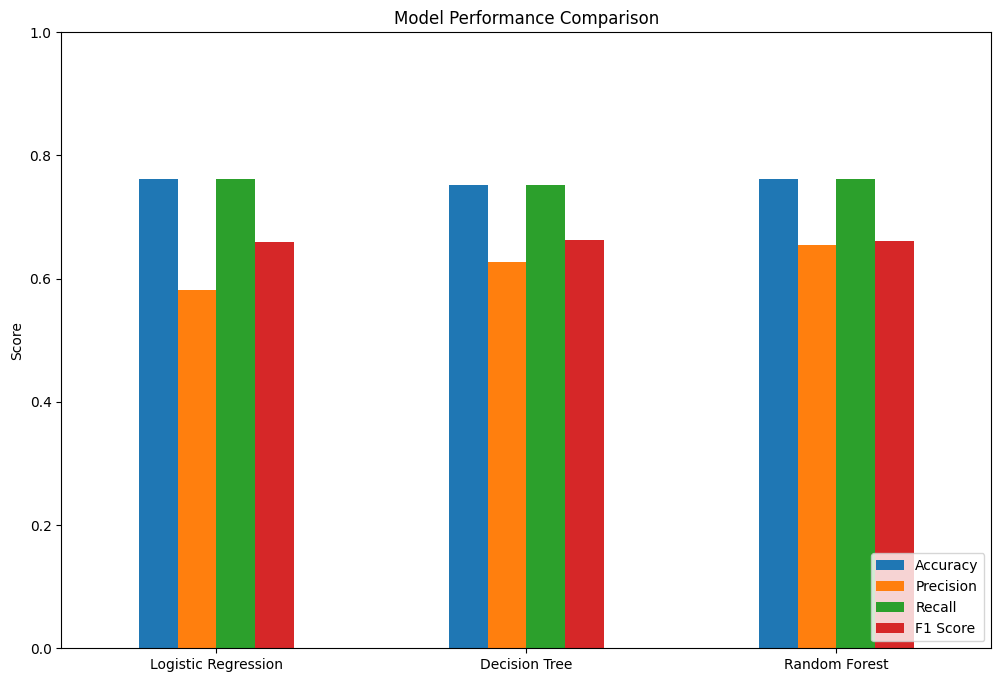

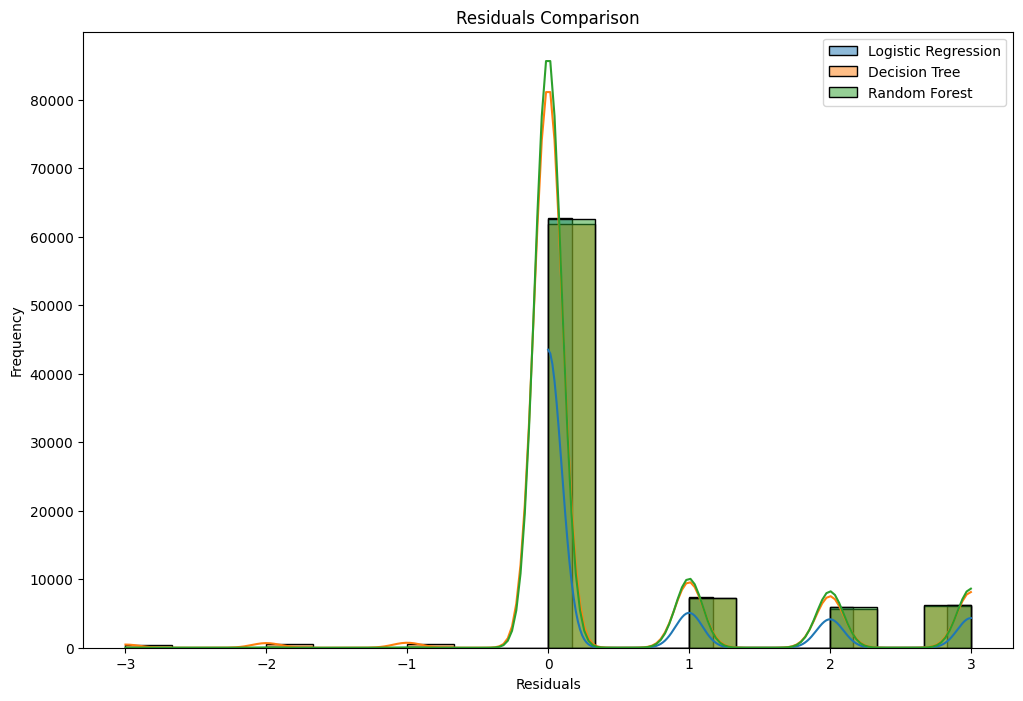

In [14]:
from sklearn.linear_model import LogisticRegression


df = pd.read_csv('combine.csv')

X = df[['Area Difference', 'Perimeter Difference', 'Center Distance']]
y = df['Damage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred

metrics = {}
for name, y_pred in predictions.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    metrics[name] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

metrics_df = pd.DataFrame(metrics).T

plt.figure(figsize=(12, 8))
metrics_df.plot(kind='bar', ax=plt.gca())
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(12, 8))
for name, y_pred in predictions.items():
    sns.histplot(y_test - y_pred, kde=True, label=name)

plt.title("Residuals Comparison")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()
